A quick notebook for comparing the zigzag and hilbert embeddings on CIFAR-10

In [1]:
# Imports
import torch
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim

from fastai.basics import *
from timm.loss import SoftTargetCrossEntropy


import sys
sys.path.append('..')

from src.tokenizers.hilbert_embedding import HilbertEmbedding
from src.tokenizers.random_embedding import RandomEmbedding
from src.tokenizers.zigzag_embedding import ZigzagEmbedding
from src.models.vit import VisionTransformer
from src.models.altvit import SimpleViT, HilbertViT
from src.training.scheduler import WarmupCosineScheduler
from src.training.train import train_with_mixup, evaluate

# Set global variables
torch.backends.cudnn.benchmark = True

/home/remco/.local/lib/python3.10/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(
/home/remco/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


Initialize the enviroment. Like deciding on the device, dataset, and model.
Here we use the `torchvision` library to load the CIFAR-10 dataset and a vision transformer.

In [2]:
def init_hilbert_model():
    """Initialize the Hilbert model."""
    patch_embed = HilbertEmbedding(
        img_size=128,
        patch_size=16,
        in_channels=3,
        embed_dim=256
    )

    model = VisionTransformer(
        patch_embed=patch_embed,
        depth=6,
        n_heads=4,
        mlp_dim=512,
        num_classes=10
    ).to(device)

    optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.00005, betas=(0.9, 0.999))

    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=30,
        eta_min=0.0001
    )

    return model, optimizer, scheduler

def init_zigzag_model():
    """Initialize the Zigzag model."""
    patch_embed = ZigzagEmbedding(
        img_size=128,
        patch_size=16,
        in_channels=3,
        embed_dim=256
    )

    model = VisionTransformer(
        patch_embed=patch_embed,
        depth=6,
        n_heads=4,
        mlp_dim=512,
        num_classes=10
    ).to(device)


    optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.00005, betas=(0.9, 0.999))

    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=30,
        eta_min=0.0001
    )

    return model, optimizer, scheduler

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_criterion = SoftTargetCrossEntropy()
test_criterion = nn.CrossEntropyLoss()


Now we're going to load in the dataset and model. For now we've implemented CIFAR-10

In [3]:
def load_data(dataset_name):
    """Load and return PyTorch-ready datasets."""
    if dataset_name == 'cifar10':
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])
        train_set = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
        test_set = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
        return train_set, test_set

    elif dataset_name == 'imagenette':
        path = untar_data(URLs.IMAGENETTE_320)
        normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225])

        transform_train = transforms.Compose([
            transforms.RandomResizedCrop(128, scale=(0.08, 1.0)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize,
            transforms.RandomErasing(p=0.25, scale=(0.02, 0.33), ratio=(0.3, 3.3), value='random')
        ])

        transform_val = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(128),
            transforms.ToTensor(),
            normalize
        ])

        train_dataset = datasets.ImageFolder(os.path.join(path, 'train'), transform=transform_train)
        val_dataset = datasets.ImageFolder(os.path.join(path, 'val'), transform=transform_val)

        return train_dataset, val_dataset

    else:
        raise ValueError(f"Dataset '{dataset_name}' not supported.")

train_set, test_set = load_data('imagenette')
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

Visualize the dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.3469253..3.9669716].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9466565..2.465708].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6051416].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.1817195..4.2454524].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5877128].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.3366213..4.0098

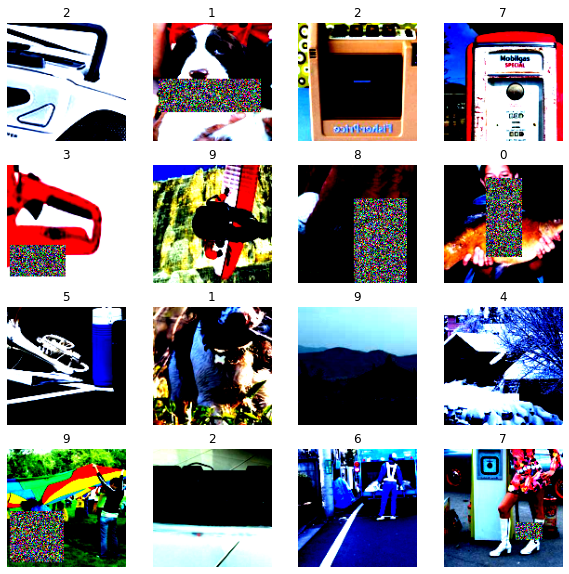

In [4]:
# Show 16 random images from the training set
def show_images(images, labels):
    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
    for i in range(16):
        ax = axes[i // 4, i % 4]
        ax.imshow(images[i].permute(1, 2, 0).numpy())
        ax.set_title(labels[i].item())
        ax.axis('off')
    plt.show()

# Get a batch of images and labels
images, labels = next(iter(train_loader))
# Show the images
show_images(images, labels)

Now we're going to train the hilbert model and the zigzag model each for 10 epochs five times on the CIFAR-10 dataset.
We will save the model weights and the training history for each run.

In [5]:
iterations = 3
epochs = 10
total_steps = epochs * len(train_loader)

def train_and_evaluate_model(iterations, epochs, init_function=None):
    train_accuracies = []
    test_accuracies = []
    for iter in range(iterations):
        model, optimizer, scheduler = init_function()
        model.to(device)
        iter_train_acc = []
        iter_test_acc = []
        for epoch in range(epochs):
            train_loss, train_acc = train_with_mixup(
                model, train_loader, train_criterion, optimizer, scheduler, device
            )
            test_loss, test_acc = evaluate(model, test_loader, test_criterion, device)

            iter_train_acc.append(train_acc)
            iter_test_acc.append(test_acc)

            print(
                f"Iteration {iter+1}, Epoch {epoch+1}: "
                f"Train Loss={train_loss:.4f}, Acc={train_acc:.4f}, "
                f"Test Loss={test_loss:.4f}, Acc={test_acc:.4f}"
            )
        train_accuracies.append(iter_train_acc)
        test_accuracies.append(iter_test_acc)
    return train_accuracies, test_accuracies

train_accuracies_zigzag, test_accuracies_zigzag = train_and_evaluate_model(
    iterations, epochs, init_zigzag_model)
train_accuracies_hilbert, test_accuracies_hilbert = train_and_evaluate_model(
    iterations, epochs, init_hilbert_model)

Training:   1%|          | 2/296 [00:00<00:19, 14.89it/s]    

Iteration 1, Epoch 1: Train Loss=2.1084, Acc=0.2439, Test Loss=1.9651, Acc=0.3228


Training:   1%|          | 2/296 [00:00<00:19, 15.17it/s]    

Iteration 1, Epoch 2: Train Loss=1.9205, Acc=0.3366, Test Loss=1.7190, Acc=0.4247


Training:   1%|          | 2/296 [00:00<00:19, 15.00it/s]    

Iteration 1, Epoch 3: Train Loss=1.7971, Acc=0.3917, Test Loss=1.5877, Acc=0.4713


Training:   1%|          | 2/296 [00:00<00:18, 15.77it/s]    

Iteration 1, Epoch 4: Train Loss=1.7229, Acc=0.4167, Test Loss=1.4976, Acc=0.4983


Training:   1%|          | 2/296 [00:00<00:21, 13.73it/s]    

Iteration 1, Epoch 5: Train Loss=1.6634, Acc=0.4447, Test Loss=1.5308, Acc=0.4851


Training:   1%|          | 2/296 [00:00<00:19, 15.10it/s]    

Iteration 1, Epoch 6: Train Loss=1.6070, Acc=0.4676, Test Loss=1.4062, Acc=0.5302


KeyboardInterrupt: 

Now we're going to visualize the training history of the hilbert and zigzag models.

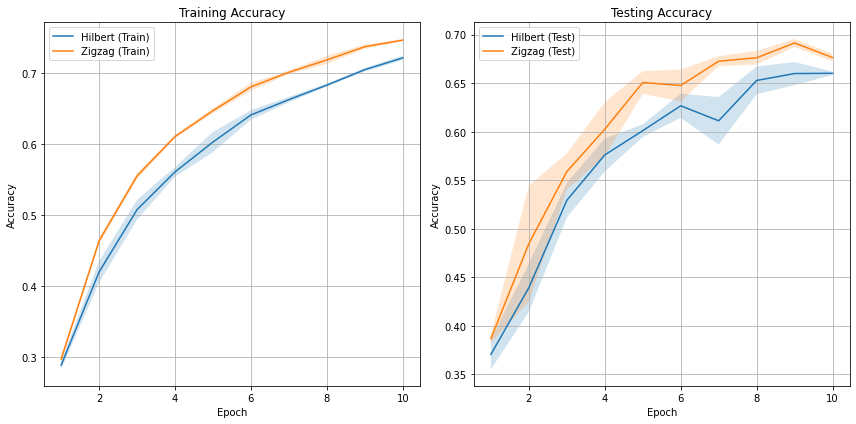

In [ ]:
# Convert to numpy arrays
train_hilbert = np.array(train_accuracies_hilbert)
test_hilbert = np.array(test_accuracies_hilbert)
train_zigzag = np.array(train_accuracies_zigzag)
test_zigzag = np.array(test_accuracies_zigzag)

# Compute mean and std deviation
def compute_stats(data):
    return data.mean(axis=0), data.std(axis=0)

train_h_mean, train_h_std = compute_stats(train_hilbert)
test_h_mean, test_h_std = compute_stats(test_hilbert)
train_z_mean, train_z_std = compute_stats(train_zigzag)
test_z_mean, test_z_std = compute_stats(test_zigzag)

# Plotting
epochs_range = np.arange(1, epochs + 1)

plt.figure(figsize=(12, 6))

# Training accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_h_mean, label="Hilbert (Train)")
plt.fill_between(epochs_range, train_h_mean - train_h_std, train_h_mean + train_h_std, alpha=0.2)
plt.plot(epochs_range, train_z_mean, label="Zigzag (Train)")
plt.fill_between(epochs_range, train_z_mean - train_z_std, train_z_mean + train_z_std, alpha=0.2)
plt.title("Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# Testing accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, test_h_mean, label="Hilbert (Test)")
plt.fill_between(epochs_range, test_h_mean - test_h_std, test_h_mean + test_h_std, alpha=0.2)
plt.plot(epochs_range, test_z_mean, label="Zigzag (Test)")
plt.fill_between(epochs_range, test_z_mean - test_z_std, test_z_mean + test_z_std, alpha=0.2)
plt.title("Testing Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()